In [1]:
import pandas as pd

df = pd.read_parquet("imagenette/active_labeled.parquet")


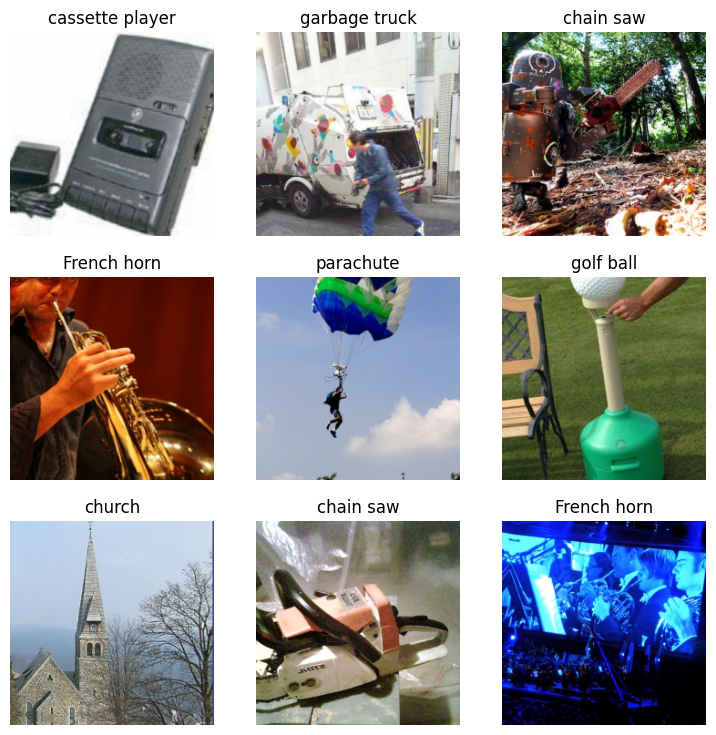

In [2]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(320),
    batch_tfms=aug_transforms(size=224),
)

dls.show_batch()

In [3]:
import timm
timm.list_models("*convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny',
 'test_convnext',
 'test_convnext2',
 'test_convnext3']

In [4]:
learn = vision_learner(dls, "convnext_tiny_in22k", metrics=accuracy).to_fp16()
learn.fine_tune(5, 5e-3)


/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.278809,1.388034,0.666667,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.539774,0.559608,0.777778,00:01
1,0.419776,0.222133,0.944444,00:01
2,0.309962,0.091586,0.944444,00:01
3,0.226807,0.059562,0.944444,00:01
4,0.183378,0.051969,0.944444,00:01


In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_names):
        super().__init__()
        self.model = model
        self.layer_names = layer_names
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def get_layer(model, name):
            # Split the name into parts
            parts = name.split('.')
            # Navigate through the model
            curr_layer = model
            for part in parts:
                curr_layer = curr_layer[int(part)]
            return curr_layer

        for name in self.layer_names:
            layer = get_layer(self.model, name)
            self.hooks.append(layer.register_forward_hook(self._get_activation))

    def _get_activation(self, module, input, output):
        self.features[module] = output

    def forward(self, x):
        self.features = {}
        _ = self.model(x)
        return [self.features[dict([*self.model.named_modules()])[name]] for name in self.layer_names]


In [6]:
learn.model

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_path): Identity()
          

In [7]:
for name, module in learn.model.named_modules():
    print(f"Name: {name}")
    print(f"Module: {module}")
    print("-" * 50)  # Separator for better readability

Name: 
Module: Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_path): Identi

In [8]:
extractor = FeatureExtractor(learn.model, ['1.4'])

In [9]:
batch = dls.valid.one_batch()
features = extractor(batch[0])
embeddings = features[0].squeeze()

In [10]:
embeddings.shape

torch.Size([16, 512])

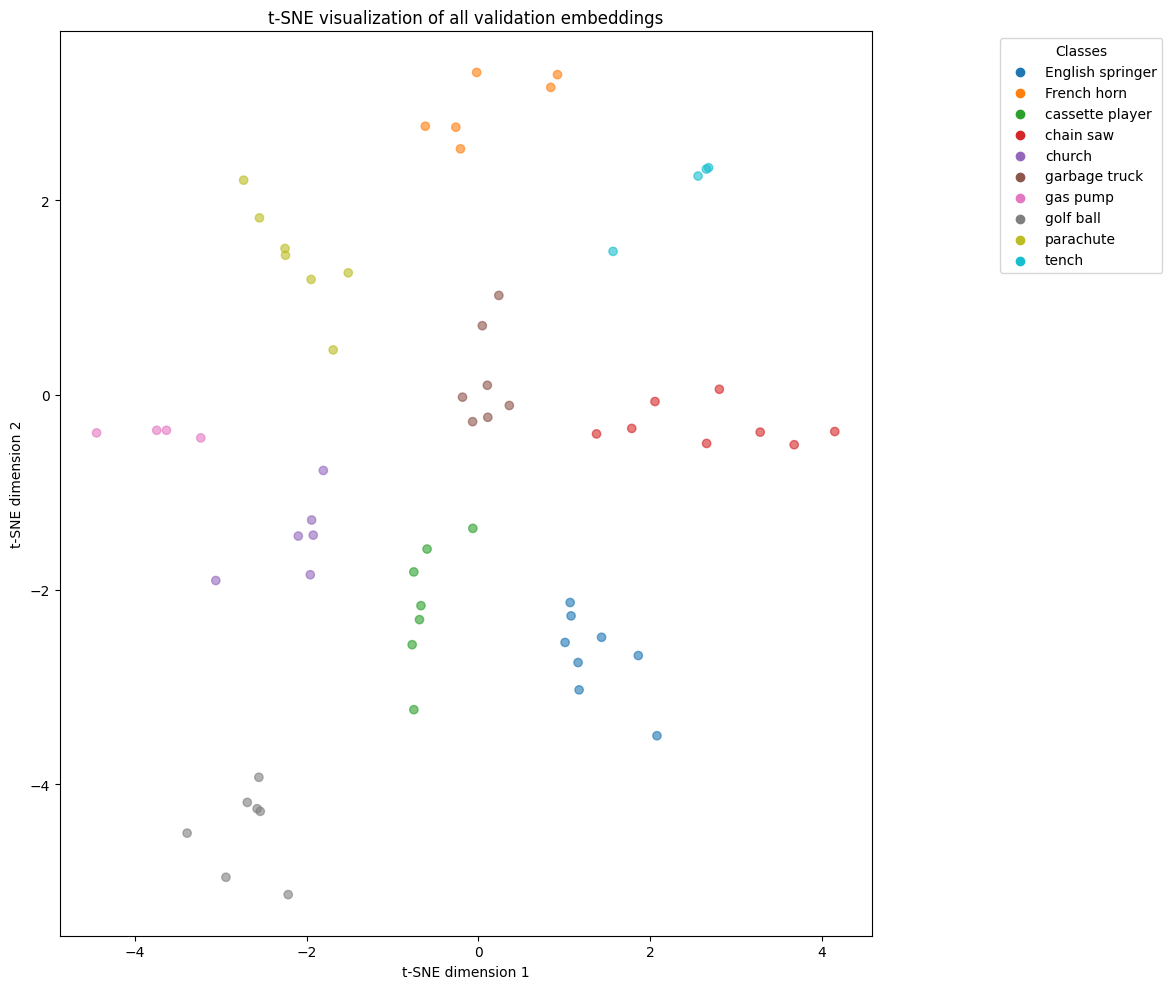

In [11]:
from sklearn.manifold import TSNE

all_embeddings = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for inference
    for batch in dls.train:
        features = extractor(batch[0])
        embeddings = features[0].squeeze()
        all_embeddings.append(embeddings.cpu())
        all_labels.append(batch[1].cpu())

# Concatenate all batches
all_embeddings = torch.cat(all_embeddings, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Get class names from the DataLoader
class_names = dls.vocab

# Convert to numpy for t-SNE
embeddings_np = all_embeddings.numpy()
labels_np = all_labels.numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(class_names)]
plt.legend(handles=legend_elements, title="Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('t-SNE visualization of all validation embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()  
plt.show()

In [12]:
all_embeddings.shape

torch.Size([64, 512])

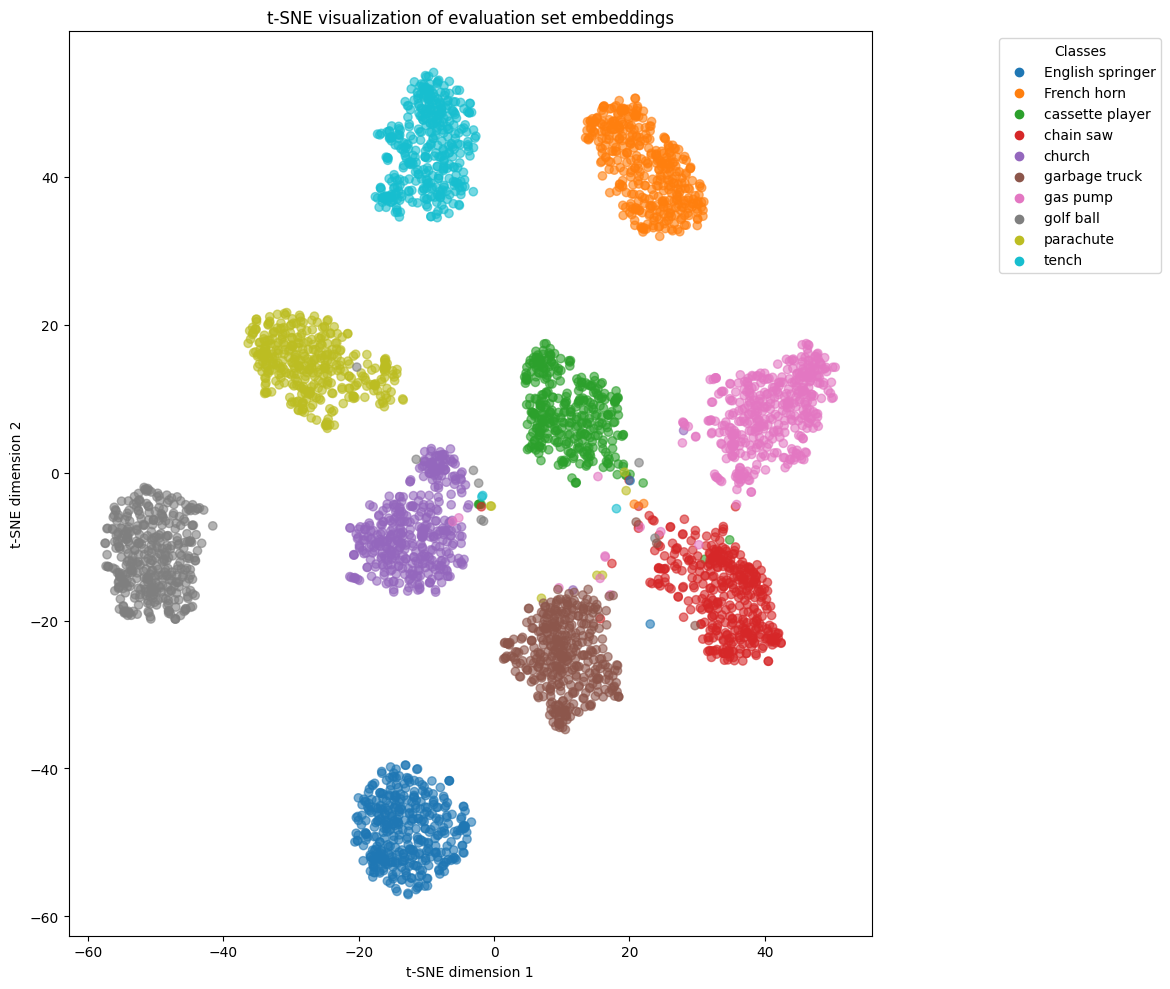

Test embeddings shape: torch.Size([3925, 512])


In [13]:
# Load test data
test_df = pd.read_parquet("imagenette/evaluation_samples.parquet")

# Create test DataLoader
test_dl = learn.dls.test_dl(test_df, with_labels=True, bs=16)

# Extract embeddings from test set
test_embeddings = []
test_labels = []

with torch.no_grad():
    for batch in test_dl:
        features = extractor(batch[0])
        embeddings = features[0].squeeze()
        test_embeddings.append(embeddings.cpu())
        test_labels.append(batch[1].cpu())

# Concatenate all batches
test_embeddings = torch.cat(test_embeddings, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# Convert to numpy and create t-SNE visualization
embeddings_np = test_embeddings.numpy()
labels_np = test_labels.numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(dls.vocab)]
plt.legend(handles=legend_elements, title="Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('t-SNE visualization of evaluation set embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.show()

# Print shape of test embeddings
print(f"Test embeddings shape: {test_embeddings.shape}")

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


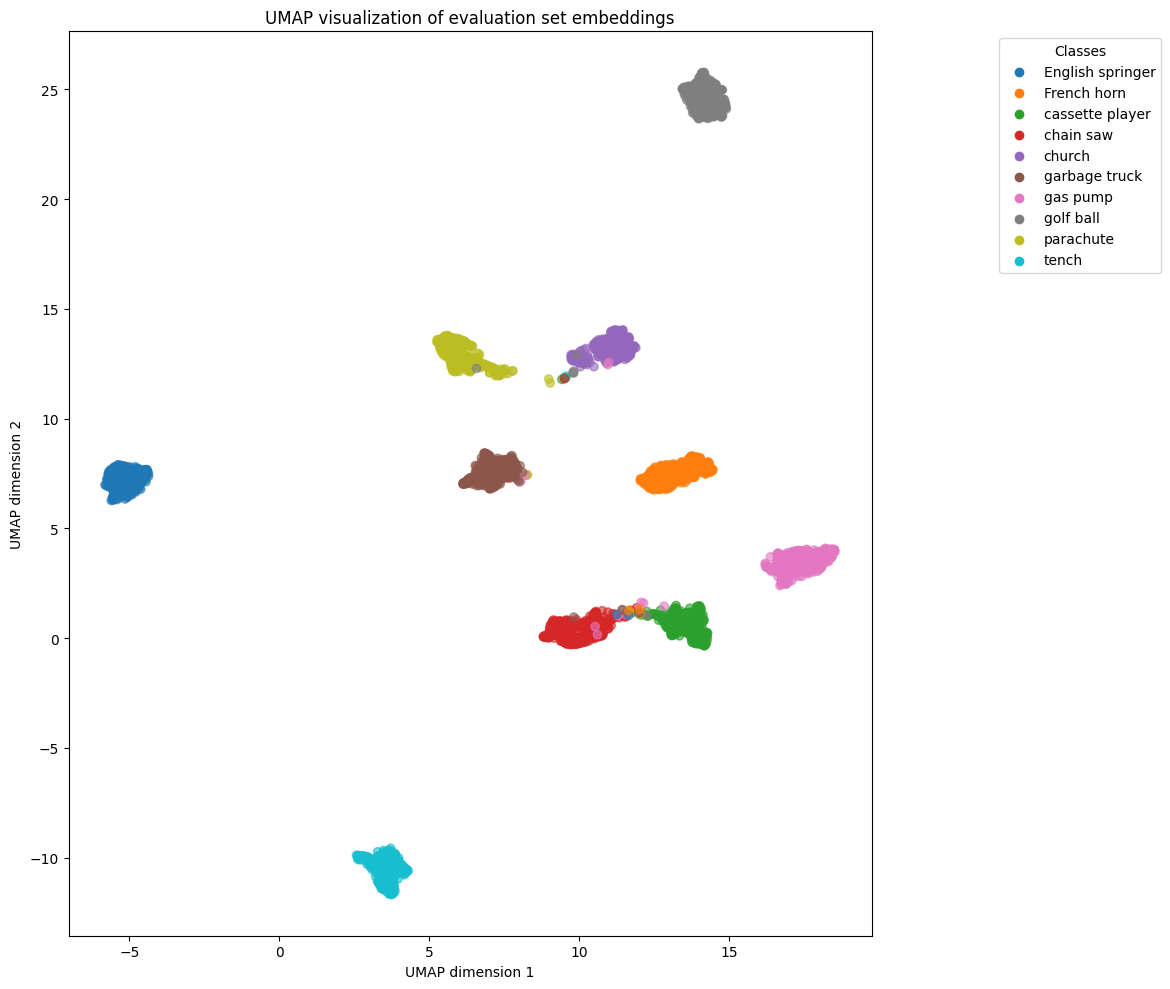

Test embeddings shape: torch.Size([3925, 512])


In [14]:


# Import UMAP
from umap import UMAP

# Convert to numpy and create UMAP visualization
embeddings_np = test_embeddings.numpy()
labels_np = test_labels.numpy()

# Apply UMAP instead of t-SNE
umap = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(dls.vocab)]
plt.legend(handles=legend_elements, title="Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('UMAP visualization of evaluation set embeddings')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.tight_layout()
plt.show()

# Print shape of test embeddings
print(f"Test embeddings shape: {test_embeddings.shape}")

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


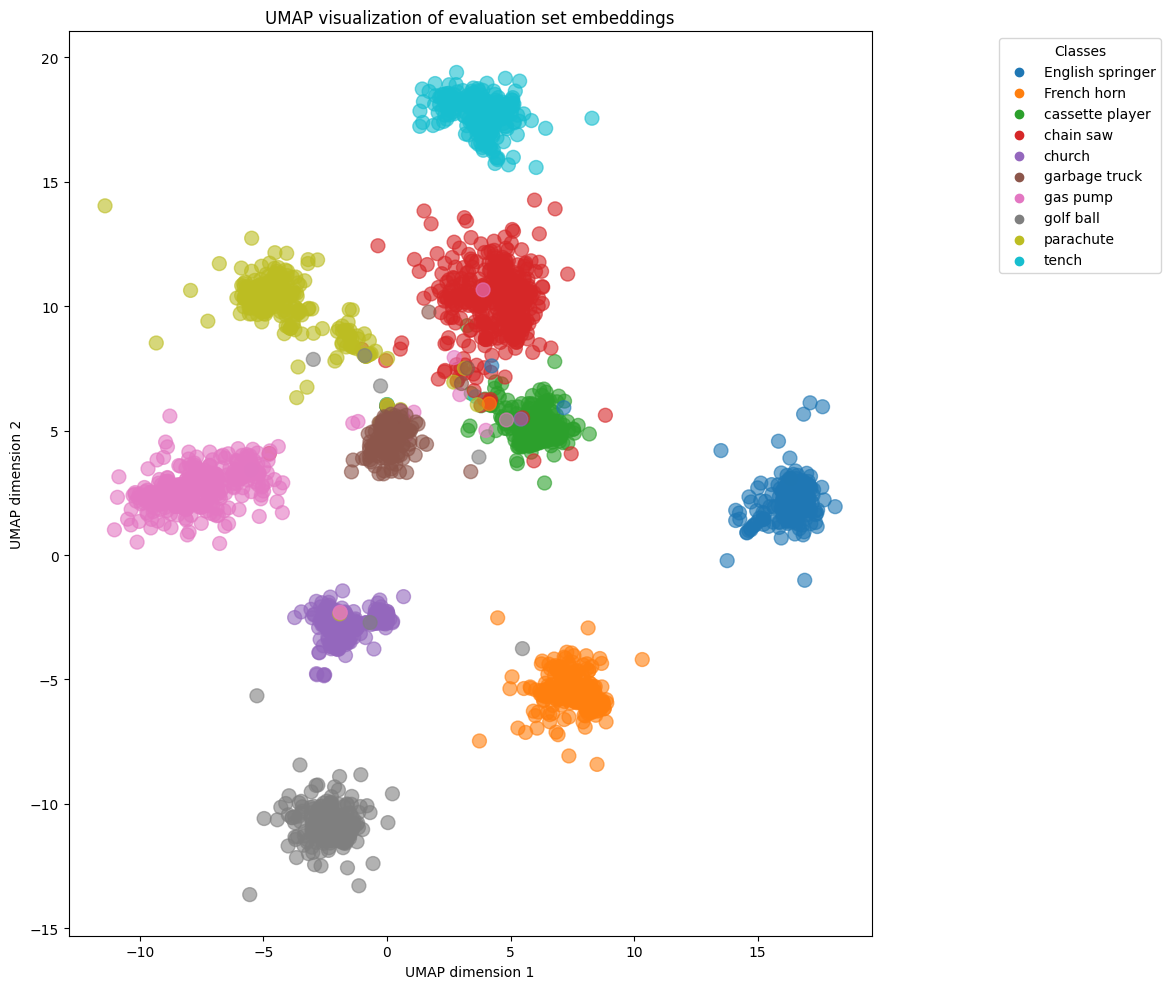

In [15]:
from umap import UMAP

# Convert to numpy and create UMAP visualization
embeddings_np = test_embeddings.numpy()
labels_np = test_labels.numpy()

# Apply UMAP with parameters for tighter clustering
umap = UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=5,        # Reduced from 15 - focuses more on local structure
    min_dist=0.0,        # Reduced from 0.1 - allows points to pack more tightly
    metric='euclidean',  # Standard metric for image embeddings
    densmap=True,        # Helps to create more distinct clusters
    n_epochs=500         # Increased epochs for better convergence
)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6,
                     s=100)  # Increased marker size

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(dls.vocab)]
plt.legend(handles=legend_elements, title="Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('UMAP visualization of evaluation set embeddings')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.tight_layout()
plt.show()